In [0]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [0]:
# Global Hyper-parameters
batch_size = 32
num_workers = 1
shuffle = False
image_with = 256
image_height = 256
num_epochs = 11
lr = 0.0002 # 2e-4
K = 2 #number of steps for the discriminator    

In [0]:
# Download dataset      
!wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz

--2020-04-02 11:40:13--  https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz.4’

facades.tar.gz.4    100%[===================>]  28.77M  84.9MB/s    in 0.3s    

2020-04-02 11:40:13 (84.9 MB/s) - ‘facades.tar.gz.4’ saved [30168306/30168306]



In [0]:
!tar -xf facades.tar.gz

In [0]:
# Images Directories
import os

dataset_dir = 'facades'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')


In [0]:
# Custom Image Dataset

import os
import numpy as np
from PIL import Image
import torchvision as tv

class FacadesDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(root)))

    def __getitem__(self, idx):
        # load images
        img_path = os.path.join(self.root, self.imgs[idx])
        img = np.array(Image.open(img_path).convert("RGB"))

        # split image to source and target
        h, w, d = img.shape
        w = w // 2
        real_image = img[:, :w, :]
        input_image = img[:, w:, :]

        # apply preprocessing transforms
        if self.transforms is not None:
            input_image = self.transforms(Image.fromarray(input_image))
            real_image = self.transforms(Image.fromarray(real_image))

        return input_image, real_image

    def __len__(self):
        return len(self.imgs)

transforms = tv.transforms.Compose([
    tv.transforms.Resize((268, 268)),
    tv.transforms.RandomCrop((image_with, image_height)),
    tv.transforms.Lambda(lambda img: (np.array(img) / 127.5) - 1), 
    tv.transforms.ToTensor(),
])

train_set = FacadesDataset(root=train_dir, transforms=transforms)
val_set = FacadesDataset(root=val_dir, transforms=transforms)
test_set = FacadesDataset(root=test_dir, transforms=transforms)

In [0]:
# Data Loaders
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers
)

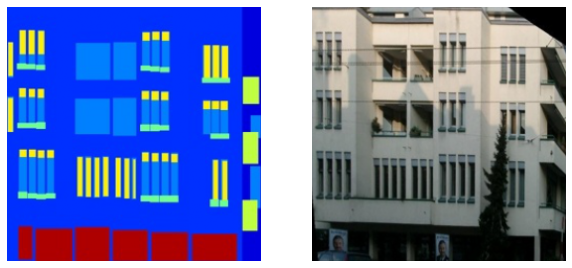

In [0]:
# Visualize Images

from matplotlib import pyplot as plt
from math import sqrt
%matplotlib inline

# load a batch
src_imgs, tgt_imgs = next(iter(train_loader))

# visualize batch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 9))

ax1.axis("off")
ax2.axis("off")

ax1.imshow(np.transpose((src_imgs[0] + 1) / 2, (1, 2, 0)))
ax2.imshow(np.transpose((tgt_imgs[0] + 1) / 2, (1, 2, 0)))


In [0]:
# Downsample Block

def ConvBlock(in_filters, out_filters, kernel, batch_norm, padding):
    if batch_norm:
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_filters, 
                out_channels=out_filters,
                kernel_size=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.BatchNorm2d(
                num_features=out_filters
            ),
            torch.nn.LeakyReLU(0.2)
        )
    else:
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.LeakyReLU(0.2)
        )

In [0]:
# Upsample Block
def ConvTransBlock(in_filters, out_filters, kernel, dropout, padding):
    if dropout:
        return torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=kernel,
                stride=2,
                bias=False,
                padding=padding
            ),
            torch.nn.BatchNorm2d(
                num_features=out_filters
            ),
            torch.nn.Dropout2d(0.5),
            torch.nn.LeakyReLU(0.2)
        )
    else:
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                 kernel_size=kernel,
                 stride=2,
                 bias=False,
                 padding=padding
            ),
            torch.nn.BatchNorm2d(
                num_features=out_filters
            ),
            torch.nn.LeakyReLU(0.2)
        )

![alt text](https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png)

In [0]:
# Generator Class
class Generator(torch.nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.unet_down = torch.nn.Sequential(
            ConvBlock(3, 64, 4, False, 1), # (bs, 128, 128, 64)
            ConvBlock(64, 128, 4, True, 1), # (bs, 64, 64, 128)
            ConvBlock(128, 256, 4, True, 1), # (bs, 32, 32, 256)
            ConvBlock(256, 512, 4, True, 1), # (bs, 16, 16, 512)
            ConvBlock(512, 512, 4, True, 1), # (bs, 8, 8, 512)
            ConvBlock(512, 512, 4, True, 1), # (bs, 4, 4, 512)
            ConvBlock(512, 512, 4, True, 1), # (bs, 2, 2, 512)
            ConvBlock(512, 512, 4, True, 1) # (bs, 1, 1, 512)
        )
        
        self.unet_up = torch.nn.Sequential(
            ConvTransBlock(512, 512, 4, True, 1), # (bs, 2, 2, 1024)
            ConvTransBlock(1024, 512, 4, True, 1), # (bs, 4, 4, 1024)
            ConvTransBlock(1024, 512, 4, True, 1), # (bs, 8, 8, 1024)
            ConvTransBlock(1024, 512, 4, False, 13), # (bs, 16, 16, 1024)
            ConvTransBlock(1024, 256, 4, False, 25), # (bs, 32, 32, 512)
            ConvTransBlock(512, 128, 4, False, 49), # (bs, 64, 64, 256)
            ConvTransBlock(256, 64, 4, False, 97) # (bs, 128, 128, 128)
        )
        
        self.last = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=128,
                out_channels=3,
                kernel_size=2,
                stride=2,
                padding=0,
                bias=False
            ),
            torch.nn.Tanh()
        )
    
    def forward(self, inputs):
        
        skips = []
        for layer in self.unet_down:
            outputs = layer(inputs)
            skips.append(outputs)
            inputs = outputs
        
        rev_skips = reversed(skips[:-1])  # notice down has one more layer than up path
        
        for layer, skip in zip(self.unet_up, rev_skips):
            outputs = layer(inputs)  # first layer in upward takes the output from down directly w/o concat
            inputs = torch.cat(
                (outputs, skip), 1
            )
        
        return self.last(inputs)
            

In [0]:
# Discriminator Class (Patch GAN)
# Every 70x70x3 patch is represented by a 30x30x1 output
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = torch.nn.Sequential( # (bs, 256, 256, 6)
            ConvBlock(6, 64, 4, False, 1), # (bs, 128, 128, 64)
            ConvBlock(64, 128, 4, True, 1), # (bs, 64, 64, 128)
            ConvBlock(128, 256, 4, True, 1), # (bs, 32, 32, 256)
            torch.nn.ZeroPad2d(padding=1), # (bs, 34, 34, 256)
            torch.nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=4,
                stride=1,
                bias=False
            ), # (bs, 31, 31, 512)
            torch.nn.BatchNorm2d(
                num_features=512
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.ZeroPad2d(padding=1),
            torch.nn.Conv2d(
                in_channels=512,
                out_channels=1,
                kernel_size=4,
                stride=1,
                bias=False
            ), # (bs, 30, 30, 1)
            torch.nn.Sigmoid()
        )

    def forward(self, inputs):
        return self.net(inputs)

In [0]:
# Initial Models
netD = Discriminator().to(device)
netG = Generator().to(device)

# Optimizers
optimizerD = torch.optim.Adam(
    netD.parameters(),
    lr=lr,
    betas=(0.5, 0.9)
)

optimizerG = torch.optim.Adam(
    netG.parameters(),
    lr=lr,
    betas=(0.5, 0.9)
)

In [0]:
Lambda = 100
bce_loss = torch.nn.BCELoss()
mae_loss = torch.nn.L1Loss()

real_labels = torch.ones(batch_size, 1, 30, 30).to(device)
fake_labels = torch.zeros(batch_size, 1, 30, 30).to(device)

In [0]:
def trainD(src_images, tgt_images):
    src_images = src_images.to(device).float()
    tgt_images = tgt_images.to(device).float()

    fake_images = netG(src_images)

    optimizerD.zero_grad()

    real_outputs = netD(
        torch.cat((src_images, tgt_images) , 1)
    )

    fake_output = netD(
        torch.cat ((src_images, fake_images), 1)
    )
    
    d_x = bce_loss(real_outputs, real_labels) # real or fake
    d_g_z = bce_loss(fake_output, fake_labels) # as realistic ac possible

    loss = d_x + d_g_z

    loss.backward() # computes dloss/dx for every parameter x which has requires_grad=True.
    # x.grad += dloss/dx
    
    optimizerD.step() # optimizer.step updates the value of x using the gradient x.grad. 
    # x += -lr * x.grad
    
    return loss

In [0]:
# Train Generator

def trainG(src_images, tgt_images):
    src_images = src_images.to(device).float()
    tgt_images = tgt_images.to(device).float()

    netG.zero_grad()
    
    fake_images = netG(src_images)

    outputs = netD(
        torch.cat(
            (src_images, fake_images), 1
        )
    )

    loss_a = bce_loss(outputs, real_labels)
    loss_b = mae_loss(fake_images, tgt_images)
    
    loss = loss_a + (Lambda * loss_b)

    loss.backward()

    optimizerG.step()
    
    return loss

In [0]:
from math import floor


# https://pytorch.org/docs/stable/tensorboard.html
from torch.utils.tensorboard import SummaryWriter


# Writer will output to ./runs/ directory by default
tb_writer = SummaryWriter()


# fixed inputs
fixed_inputs, _ = next(iter(train_loader))
fixed_inputs = fixed_inputs.to(device).float()


import os

# checkpoints
if os.path.exists('section-6-pix2pix-optim-d.pytorch'):
    optimizerD.load_state_dict(torch.load('section-6-pix2pix-optim-d.pytorch'))
    
if os.path.exists('section-6-pix2pix-optim-g.pytorch'):
    optimizerG.load_state_dict(torch.load('section-6-pix2pix-optim-g.pytorch'))

if os.path.exists('section-6-pix2pix-network-d.pytorch'):
    netD.load_state_dict(torch.load('section-6-pix2pix-network-d.pytorch'))

if os.path.exists('section-6-pix2pix-network-g.pytorch'):
    netG.load_state_dict(torch.load('section-6-pix2pix-network-g.pytorch'))



num_steps = len(train_set) // batch_size

for epoch in range(num_epochs):
    
    d_loss = 0
    g_loss = 0
    
    for i, (src_images, tgt_images) in enumerate(train_loader):

        if i == num_steps:
            break

        for k in range(K):
            
            d_loss += trainD(
                 src_images,
                 tgt_images
            )
        
        d_loss /= 2

        g_loss += trainG(src_images, tgt_images)

    
    # Log & save checkpoint only every X epochs
    if epoch % 10 == 0:
        
        # G & D Loss
        print(
            "E:{}, G Loss:{}, D Loss:{}".format(
                epoch,
                g_loss / num_steps,
                d_loss / num_steps
            )
        )
        
        # checkpoints
        torch.save(optimizerD.state_dict(), 'section-6-pix2pix-optim-d.pytorch')
        torch.save(optimizerG.state_dict(), 'section-6-pix2pix-optim-g.pytorch')
        torch.save(netD.state_dict(), 'section-6-pix2pix-network-d.pytorch')
        torch.save(netG.state_dict(), 'section-6-pix2pix-network-g.pytorch')
                
        generated = netG(fixed_inputs).detach().cpu()

        grid = tv.utils.make_grid(
            generated,
            nrow=5,
            padding=10,
            pad_value=1,
            normalize=True
        )

        tb_writer.add_image(
            'Pix2Pix/Output',
            grid,
            epoch
        )

E:0, G Loss:41.98854064941406, D Loss:0.025652993470430374
E:10, G Loss:47.26759338378906, D Loss:2.1550076780840755e-05
